<a href="https://colab.research.google.com/github/mkalmano/congressional-analysis/blob/main/Notebook_Proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Foodstamps in Democrat vs Republican Districts**

In [ ]:
# first some initial setup of libraries we will be using
import pandas as pd # this is the main library used in python for manipulating data. 
import json # this is a library to parse json (javascript object notation)
from urllib.request import urlopen # library to read data from a URL
import matplotlib.pyplot as plt # visualization library we will use that integrates with pandas

## Reasoning and Hypothesis

Many people living in the United States are impacted by low wages and need nutritional support and government assistance. We were curious about this data because historically it is perceived that many Democratic cities have high homelessness rates and common Republican argument is that Democrats want "handouts". We wanted to see if the data backs up this theory. We chose to look at foodstamps as the criteria defining need of governmemt support. 

**Hypothesis:** The districts with individuals who recieve the most amount of foodstamps are mostly Democrat. 

## Read in Census Data

In [ ]:
# We are reading in the data we want from ACS 2021. The API returns json data. Try copy and pasting the link yourself in a browser to see what the raw data looks like.
url="https://api.census.gov/data/2021/acs/acs1?get=NAME,B22010_001E,B22010_002E,B22010_005E&for=congressional%20district:*&in=state:*"

# store the response of URL
response = urlopen(url)

# storing the JSON response from url in data
data_json = json.loads(response.read())
data_json.pop(0) # the first row of data is header information which we don't need, so pop removes that from the dataset.

# Hand populate the columns based on the variable descriptions census.gov documents here: https://api.census.gov/data/2021/acs/acs1/variables.html. Note they correspond back to the variable names I included in the URL above.
cols = ['District Name','Total Households','Recieved Foodstamps', 'No Foodstamps', 'State code', 'district number']

acs_df = pd.DataFrame(data_json, columns = cols)

# time to do some basic cleanup of the data. We will need to extract the district number and state in a regular format so we can later join with the party data.
acs_df[['District', 'State']] = acs_df['District Name'].str.split(',', expand=True)
acs_df['district number'] = pd.to_numeric(acs_df['district number'])

acs_df['State'] = acs_df['State'].str.strip()

# Let's just keep the columns we need
acs_df = acs_df[['Total Households', 'Recieved Foodstamps', "No Foodstamps", 'district number', 'State']]

# take a look at the top results in the dataset
acs_df.head()

,Total Households,Recieved Foodstamps,No Foodstamps,district number,State
0,289474,29587,259887,10,Michigan
1,299804,39629,260175,4,Mississippi
2,278057,68311,209746,14,Michigan
3,306685,33726,272959,1,Michigan
4,285554,28441,257113,3,Mississippi


## Read in Party Data

In [ ]:
party_df = pd.read_csv("http://goodcsv.com/wp-content/uploads/2020/08/us-house-of-representatives-2020.csv", encoding = "ISO-8859-1")

# extract the district number from the data (it was in the format of 5th and we want that to just be 5) using a regular expression.
party_df['district number'] = party_df['District/Position'].str.extract('(\d+)')
party_df['district number'] = party_df['district number'].fillna(0)
party_df['district number'] = pd.to_numeric(party_df['district number'])
party_df['State'] = party_df['State/Territory']
party_df['State'] = party_df['State'].str.strip()
party_df['Party'] = party_df['Party'].str.strip() # remove extraneous whitespace

# Let's just keep the columns we need
party_df = party_df[['State', 'Party', "district number"]]

party_df.head(5)

,State,Party,district number
0,Louisiana,R,5
1,North Carolina,D,12
2,Alabama,R,4
3,California,D,31
4,Georgia,R,12


## Create Foodstamp Percentages

In [ ]:
# Convert the number columns into number data types so we can math on them
acs_df["Total Households"] = pd.to_numeric(acs_df['Total Households'])
acs_df["Recieved Foodstamps"] = pd.to_numeric(acs_df['Recieved Foodstamps'])
acs_df['No Foodstamps'] = pd.to_numeric(acs_df['No Foodstamps'])

# Compute some new columns based on the existing columns for later visualization
acs_df['% of households foodstamps'] = (100*acs_df['Recieved Foodstamps'])/acs_df['Total Households']
acs_df['% of households no foodstamps'] = (100*acs_df['No Foodstamps'])/acs_df['Total Households']

# now let's look at the data again
acs_df.head()

,Total Households,Recieved Foodstamps,No Foodstamps,district number,State,% of households foodstamps,% of households no foodstamps
0,289474,29587,259887,10,Michigan,10.220952,89.779048
1,299804,39629,260175,4,Mississippi,13.218303,86.781697
2,278057,68311,209746,14,Michigan,24.567265,75.432735
3,306685,33726,272959,1,Michigan,10.996951,89.003049
4,285554,28441,257113,3,Mississippi,9.959938,90.040062


## Merge Dataframes

In [ ]:
# Merge is like a sql natural join. We are joining on the State and District numbers being the same between the two sets.
merged_df = pd.merge(acs_df, party_df, on=["State", "district number"])

merged_df.describe()

,Total Households,Recieved Foodstamps,No Foodstamps,district number,% of households foodstamps,% of households no foodstamps
count,435.000000,435.000000,435.000000,435.000000,435.000000,435.000000
mean,292471.643678,36305.937931,256165.705747,10.158621,12.605225,87.394775
std,33670.787672,15208.133255,37442.167364,10.656779,5.626659,5.626659
min,183319.000000,9227.000000,140888.000000,0.000000,2.805607,52.863661
25%,273747.000000,26315.500000,235487.000000,3.000000,8.671962,84.465260
50%,292311.000000,34645.000000,258110.000000,6.000000,11.698810,88.301190
75%,311849.500000,43300.500000,278591.000000,13.000000,15.534740,91.328038
max,448949.000000,125624.000000,410144.000000,53.000000,47.136339,97.194393


## Barplot: Average % of Households Receiving Foodstamps

In [ ]:
import seaborn as sns

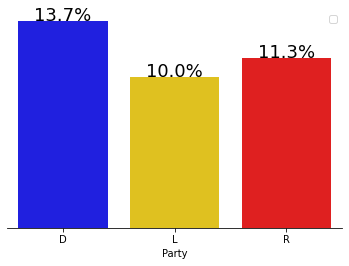

In [ ]:
average = merged_df.groupby("Party")["% of households foodstamps"].mean()

colors= {"D":"blue","L":"gold", "R": "red"}

ax=sns.barplot(x=average.index, y=average.values, palette=colors)

ax.yaxis.set_visible(False)

for i, value in enumerate(average.values):
    ax.text(i, value, f'{value:.1f}%', ha="center", fontsize=18)

sns.despine(left=True)

plt.legend()
plt.show()

## Barplot: Median % of Households Receiving Foodstamps

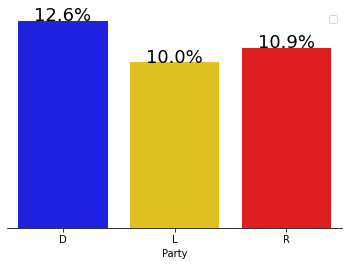

In [ ]:
median = merged_df.groupby("Party")["% of households foodstamps"].median()

colors= {"D":"blue","L":"gold", "R": "red"}

ax=sns.barplot(x=median.index, y=median.values, palette=colors)

ax.yaxis.set_visible(False)

for i, value in enumerate(median.values):
    ax.text(i, value, f'{value:.1f}%', ha="center", fontsize=18)

sns.despine(left=True)

plt.legend()
plt.show()

## Top 10 and Bottom 10 Districts

In [ ]:
df_descending = merged_df.sort_values("% of households foodstamps", ascending=False)

desc= df_descending[["Party","% of households foodstamps", "State", "district number"]]

# bottom 10 
print(desc.head(10))

    Party  % of households foodstamps         State  district number
276     D                   47.136339      New York               15
19      D                   31.727897      New York               13
227     D                   31.121851      Michigan               13
277     D                   30.736612  Pennsylvania                2
155     D                   29.298095       Florida               24
353     D                   26.675203     Wisconsin                4
347     D                   26.293892         Texas               34
411     R                   26.068994      Kentucky                5
248     D                   26.042580          Ohio               11
109     D                   25.837134    California               16


In [ ]:
df_ascending = merged_df.sort_values("% of households foodstamps")

asc = df_ascending[["Party","% of households foodstamps", "State", "district number"]]

# top 10 
print(asc.head(10))

    Party  % of households foodstamps       State  district number
315     R                    2.805607       Texas                3
242     D                    3.232621  New Jersey               11
403     D                    3.561407     Georgia                6
216     R                    3.751107    Missouri                2
112     D                    3.766951  California               18
62      D                    3.838902    Virginia               10
264     D                    3.918898    New York                3
27      D                    3.952794  New Jersey                5
28      D                    4.193566  New Jersey                7
324     D                    4.318915    Virginia               11


## % of Households Receiving Foodstamps Distribution (Dems)

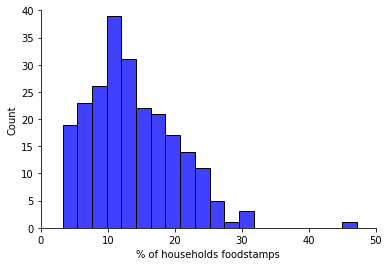

In [ ]:
df_dem = merged_df[merged_df['Party']== "D"]

sns.histplot(df_dem["% of households foodstamps"], bins = 20, color="blue")

plt.xlim(0, 50)

plt.ylim(0,40)

sns.despine()



## % of Households Receiving Foodstamps Distribution (Reps)

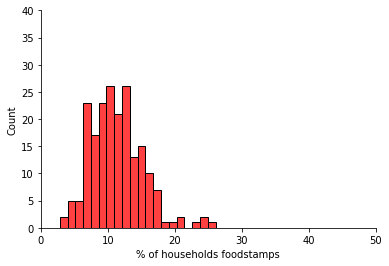

In [ ]:
df_rep = merged_df[merged_df['Party']== "R"]

sns.histplot(df_rep["% of households foodstamps"],bins = 20, color="red")

plt.xlim(0, 50)

plt.ylim(0,40)

sns.despine()

## Results of Analysis 

Given the results above and the analysis we just discussed, we can conclude that overall there is support for our hypothesis that Democratic districts have a higher percentage of people receiving foodstamps. However, Democratic districts vere towards the extreems on both sides and Republican districts have a more normal distribution.